In [ ]:
import os
import joblib
import matplotlib.pyplot as plt
import glob
import pandas as pd
import numpy as np
from scipy.signal import argrelextrema
import seaborn as sns

In [ ]:
JOINT_NAMES = [
    'Nose', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist', 'MidHip', 'RHip', 'RKnee',
    'RAnkle', 'LHip', 'LKnee', 'LAnkle', 'REye', 'LEye', 'REar', 'LEar', 'LBigToe', 'LSmallToe', 'LHeel', 'RBigToe',
    'RSmallToe', 'RHeel', 'Right Ankle', 'Right Knee', 'Right Hip', 'Left Hip', 'Left Knee', 'Left Ankle',
    'Right Wrist', 'Right Elbow', 'Right Shoulder', 'Left Shoulder', 'Left Elbow', 'Left Wrist', 'Neck (LSP)',
    'Top of Head (LSP)', 'Pelvis (MPII)', 'Thorax (MPII)', 'Spine (H36M)', 'Jaw (H36M)', 'Head (H36M)',
    'Nose', 'Left Eye', 'Right Eye', 'Left Ear', 'Right Ear'
]

#using first 44
JOINT_NAMES = JOINT_NAMES[:45]

#creating dict of joints
joint_dict = {}
for i in range(0, len(JOINT_NAMES)):
    joint_dict[JOINT_NAMES[i]] = i

In [ ]:
def load_pickles(folder='pickles', files=None):

    '''
    Loads pickle files from folder. Either specified list in files or all pkl files inside the folder.

    INPUTS
    ------
        folder : str, default 'pickles'
            Directory where pickle files are stored.
        files : list, default None
            List of files to load.

    OUTPUTS
    -------
        model_outputs : dict
            Dictionary of loaded pickle results in PHALP schema (which are also dicts).
    '''


    #storage dict
    model_outputs = {}

    #only specified files
    if files:
        for file in files:
            name = os.path.splitext(file)[0]
            model_outputs[name] = joblib.load(f'{folder}/{file}')

    #everything in pickles directory
    else:
        pickle_files = glob.glob(f'{folder}/*.pkl')
        for file in pickle_files:
            name = os.path.splitext(os.path.basename(file))[0]
            model_outputs[name] = joblib.load(file)

    return model_outputs

def extract_joints(model_output):

    '''
    Extracts joints from pickle file for every detected person.

    Basically transforms dictionary obtained through PHALP into more useful schema:

    tracklets = {

        #dict for each person
        'person_id' : {
            #dict for each joint
            'joint_name' : {
                #dict for each dimension
                'dimension':    List[numpy.float32]     #value for every detected frame
            }
        }

    }

    INPUTS
    ------
        model_output : dict
            phalp_outputs dictionary of single video.

    OUTPUTS
    -------
        tracklets : dict
            Dictionary of all tracklets in the video with their 3d_joints in 3 dimensions.
    '''

    #check how many people are in the video:
    n_tracklets = 0
    for frame in model_output.values():
        n_tracklets = max(n_tracklets, len(frame['tracked_ids']))

    #initialize joints dict with empty list for every detection
    tracklets = {n: {joint: {dim: np.empty(0) for dim in range(3)} for joint in joint_dict} for n in range(n_tracklets)}

    #loop over frames and extract joints
    for frame in model_output.values():
        for person in frame['tracked_ids']:
            person -= 1
            for joint in joint_dict:
                for dim in range(3):
                    tracklets[person][joint][dim] = np.append(tracklets[person][joint][dim], frame['3d_joints'][person][joint_dict[joint]][dim])

    return tracklets

def plot_joints_trajectory(tracklets, person_id, joint_list, dim):

    '''
    Plots joint trajectories for specified video, person, joint list and dimension.

    INPUTS
    ------
        tracklets : dict
            Dict of tracklets from video obtained thorugh extract_joints().
        person_id : int
            Index of tracked person to plot.
        joint_list : list
            List of joints to plot.
        dim : int
            Dimension to plot from camera point of view (0 - x axis, 1 - y axis, 2 - z axis).

    '''

    trajectories = {}

    for joint in joint_list:
        trajectories[joint] = tracklets[person_id][joint][dim]
        plt.plot(range(len(trajectories[joint])), trajectories[joint])

    #for title purposes
    joint_names = ' & '.join(joint_list)

    plt.legend(joint_list)
    plt.title(joint_names)
    plt.show()

def moving_average(data, window_size=3):
    """
    Apply moving average smoothing to the data.

    Parameters:
    - data: pandas Series or DataFrame
        The data to be smoothed.
    - window_size: int
        The size of the moving window.

    Returns:
    - pandas Series or DataFrame
        The smoothed data.
    """
    return data.rolling(window=window_size).mean()

def reject_outliers(data, m=1):

    cleaned_data = data[abs(data - np.mean(data)) < m * np.std(data)]
    indices = abs(data - np.mean(data)) < m * np.std(data)

    return cleaned_data, indices

def get_step_metrics(tracklets, video, person_id, dim, joint='Heel', smoothing=False):

    '''
    Calulcates bunch of step related biometrics for heels or ankles.

    INPUTS
    ------
        tracklets : dict
            Dictionary of all tracklets in the video with their 3d_joints in 3 dimensions.
        video : str
            Name of video.
        person_id : int
            Index of tracked person.
        dim : int
            Dimension to plot from camera point of view (0 - x axis, 1 - y axis, 2 - z axis).
        joint : str
            Joint on which metrics are based. Must be either Heel or Ankle.
        smoothing : bool, default False
            If True then moving average smoothing is applied with window_size 3.

    OUTPUTS
    -------
        tracklets : dict
            Dictionary of all tracklets in the video with their 3d_joints in 3 dimensions

        steps_length : np.array
            Array of step lengths.
        avg_step_length : float
            Average step length.
        speed : float
            Average speed from first to last step in m/timeframes.
        time : int
            Time from first to last step in timeframes.
        distance : float
            Distance travelled from first to last step in meters.
    '''

    assert joint in ['Heel','Ankle'], 'Joint must be heel or ankle'

    #get ankles
    r = tracklets[video][person_id][f'R{joint}'][dim]
    l = tracklets[video][person_id][f'L{joint}'][dim]

    if smoothing:
        r = np.array(moving_average(pd.DataFrame(r)))
        l = np.array(moving_average(pd.DataFrame(l)))

    #calculate difference between ankles in the dimension
    difference = np.absolute(np.subtract(r, l))

    #indices of local maxima
    maxima = argrelextrema(difference, np.greater)[0]

    #steps length
    steps_length = difference[maxima]

    #get rid of outliers
    steps_length, indices = reject_outliers(steps_length)

    #speed
    time = np.ptp(maxima[indices])
    distance = np.sum(steps_length[1:])
    speed = distance/time #meters per timeframe

    #average step
    avg_step_length = np.average(steps_length)
    
    return steps_length, avg_step_length, speed, time, distance
    

In [ ]:
#load all pickle files
model_outputs = load_pickles()

tracklets_dict = {}

for video_name, video_results in model_outputs.items():
    tracklets_dict[video_name] = extract_joints(video_results)

The structure of detections_dict we have after the above processing is as follows:

```python
    tracklets_dict = {
    
        #dict for each pickle
        'pickle_name' : {       
            #dict for each person
            'person_id' : {
                #dict for each joint
                'joint_name' : {
                    #dict for each dimension
                    'dimension':    List[numpy.float32]     #value for every detected frame
                }
            }
        }
    }
```

In [ ]:
# gives the whole trajectory of RAnkle for a second person in demo_Athletic_Male
tracklets_dict['demo_Athletic_Male'][1]['RAnkle'][0]

array([-0.14553805, -0.15515436, -0.18400419, -0.21620455, -0.23086983,
       -0.24342905, -0.25593024, -0.30283558, -0.34108073, -0.37658578,
       -0.4116593 , -0.45012948, -0.4810732 , -0.5077377 , -0.5170067 ,
       -0.4881981 , -0.42816556, -0.31806499, -0.23733389, -0.13268676,
        0.00094798,  0.14466745,  0.24901952,  0.33448508,  0.33804435,
        0.29526702,  0.24049193,  0.16595058,  0.09466116,  0.00863712,
       -0.02555204, -0.07209848, -0.13565078, -0.19507703, -0.25147718,
       -0.30293715, -0.35813764, -0.41298604, -0.45741874, -0.47601765,
       -0.45900494, -0.42634267, -0.35458586, -0.26994529, -0.1831394 ,
       -0.08746438,  0.05220147,  0.18114147,  0.28222322,  0.34171396,
        0.33675784,  0.29771033,  0.24197242,  0.16944516,  0.1051283 ,
        0.02581082, -0.02097515, -0.05976583, -0.11965127, -0.16961308,
       -0.21804643, -0.27710652, -0.33320433, -0.38515562, -0.43604267,
       -0.45017502, -0.4452287 , -0.41159728, -0.35067087, -0.27

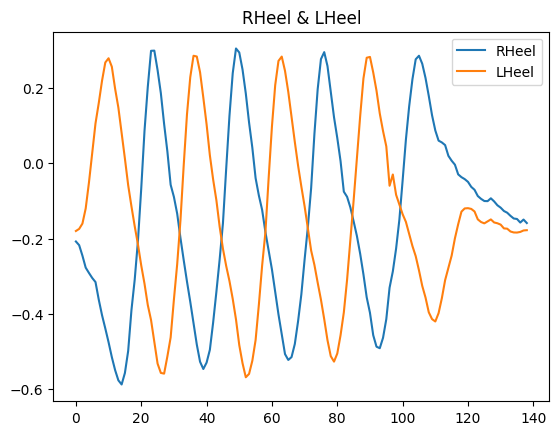

In [ ]:
#side view in x axis for the left person on demo_Athletic_Male
tracklet = tracklets_dict['demo_Athletic_Male']
person_id = 1
joint_list = ['RHeel', 'LHeel']
dim = 0

plot_joints_trajectory(tracklet, person_id, joint_list, dim)

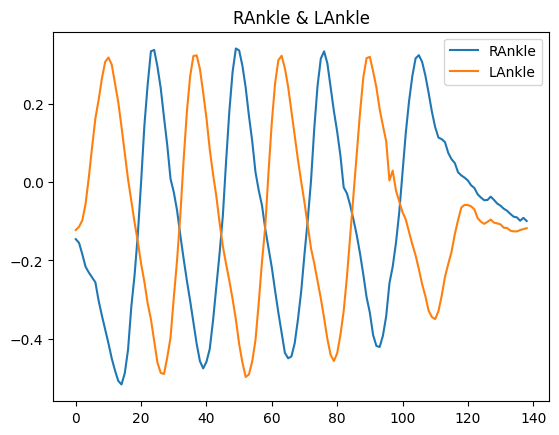

In [ ]:
#side view in x axis for the left person on demo_Athletic_Male
tracklet = tracklets_dict['demo_Athletic_Male']
person_id = 1
joint_list = ['RAnkle', 'LAnkle']
dim = 0

plot_joints_trajectory(tracklet, person_id, joint_list, dim)

1. Check smoothing DONE
2. Step length:
- calculate on one example
- compare smoothed vs not smoothed
- see if results make sense

In [ ]:
trajectory = tracklets_dict['demo_Athletic_Male'][1]['RAnkle'][0]
smoothed = moving_average(pd.DataFrame(trajectory))

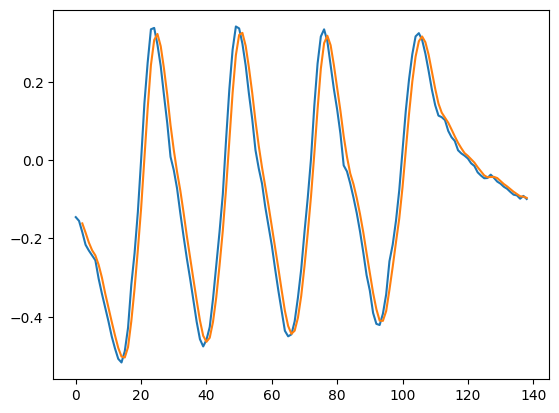

In [ ]:
plt.plot(trajectory)
plt.plot(smoothed)

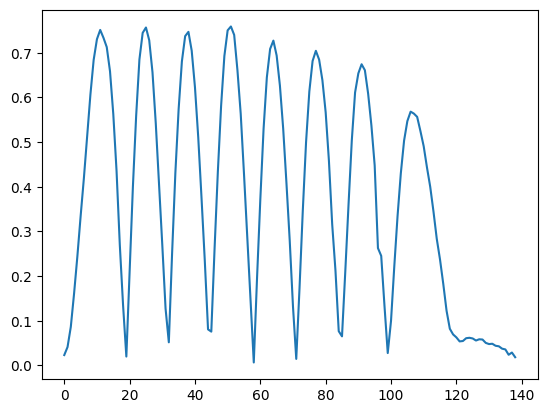

In [ ]:
rankle = tracklets_dict['demo_Athletic_Male'][1]['RAnkle'][0]
lankle = tracklets_dict['demo_Athletic_Male'][1]['LAnkle'][0]

difference = np.absolute(np.subtract(rankle, lankle))
plt.plot(difference)

In [ ]:
argrelextrema(difference, np.greater)[0]

array([ 11,  25,  38,  51,  64,  77,  91, 106, 124, 127, 131, 137],
      dtype=int64)

In [ ]:
steps_length = difference[argrelextrema(difference, np.greater)[0]]
steps_length

array([0.75093672, 0.75636622, 0.74663225, 0.75865978, 0.72700125,
       0.70417738, 0.67410365, 0.56802389, 0.0618909 , 0.05853383,
       0.04853401, 0.02886407])

In [ ]:
def reject_outliers(data, m=1):
    cleaned_data = data[abs(data - np.mean(data)) < m * np.std(data)]
    indices = abs(data - np.mean(data)) < m * np.std(data)

    return cleaned_data, indices

In [ ]:
data, indices = reject_outliers(steps_length)

In [ ]:
data

array([0.75093672, 0.75636622, 0.74663225, 0.75865978, 0.72700125,
       0.70417738, 0.67410365, 0.56802389])

In [ ]:
argrelextrema(difference, np.greater)[0][indices]

array([ 11,  25,  38,  51,  64,  77,  91, 106], dtype=int64)

In [ ]:
difference

array([0.02323402, 0.04117887, 0.0863461 , 0.16072565, 0.24336487,
       0.33343691, 0.41877462, 0.51328997, 0.60616621, 0.68404621,
       0.73021874, 0.75093672, 0.73330089, 0.71253666, 0.65830967,
       0.5628215 , 0.43552598, 0.26939672, 0.13429189, 0.01990399,
       0.20943636, 0.39930287, 0.55854006, 0.68477434, 0.7443749 ,
       0.75636622, 0.7278133 , 0.65623711, 0.54241525, 0.40587671,
       0.26961886, 0.12744746, 0.05176176, 0.25073612, 0.430739  ,
       0.57343629, 0.68063   , 0.73708349, 0.74663225, 0.7045332 ,
       0.62266766, 0.51070885, 0.37570199, 0.23539106, 0.08068936,
       0.07568863, 0.26137271, 0.43304139, 0.58103526, 0.69257742,
       0.74996907, 0.75865978, 0.73978141, 0.66077632, 0.56330796,
       0.42944102, 0.28730886, 0.14273651, 0.00662843, 0.19620054,
       0.37134689, 0.52968803, 0.64492857, 0.7083087 , 0.72700125,
       0.69359933, 0.62620677, 0.5299697 , 0.40795127, 0.27943335,
       0.13162208, 0.01461134, 0.17320433, 0.34635185, 0.49966

In [ ]:
difference[indices[0]]

array([0.75093672, 0.75636622, 0.74663225, 0.75865978, 0.72700125,
       0.70417738, 0.67410365, 0.56802389])

In [ ]:
np.ptp(argrelextrema(difference, np.greater)[0][indices])

95

In [ ]:
np.max(argrelextrema(difference, np.greater)[0][indices])

95

In [ ]:
np.sum(steps_length[1:])

5.132787223905325

In [ ]:
avg_step_length = np.average(reject_outliers(steps_length))
avg_step_length

0.7107376419007778

In [ ]:
def get_step_metrics(video, person_id, dimension, joint='Heel', smoothing=False):

    '''
    Calulcates steps length, average step length, and speed for heels or ankles.
    '''

    assert joint in ['Heel','Ankle'], 'Joint must be heel or ankle'

    #get ankles
    r = tracklets_dict[video][person_id][f'R{joint}'][dimension]
    l = tracklets_dict[video][person_id][f'L{joint}'][dimension]

    if smoothing:
        r = np.array(moving_average(pd.DataFrame(r)))
        l = np.array(moving_average(pd.DataFrame(l)))

    #calculate difference between ankles in the dimension
    difference = np.absolute(np.subtract(r, l))

    #indices of local maxima
    maxima = argrelextrema(difference, np.greater)[0]

    #steps length
    steps_length = difference[maxima]

    #get rid of outliers
    steps_length, indices = reject_outliers(steps_length)

    #speed
    time = np.ptp(maxima[indices])
    distance = np.sum(steps_length[1:])
    speed = distance/time #meters per timeframe

    #average step
    avg_step_length = np.average(steps_length)
    
    return steps_length, avg_step_length, speed, time, distance
    

In [ ]:
steps_length, avg_step_length, speed, time, distance = get_step_metrics('demo_Athletic_Male', 1, 0, smoothing=False)

In [ ]:
for whatever in [steps_length, avg_step_length, speed, time, distance]:
    print(whatever, type(whatever))

[0.77077022 0.77913165 0.76836264 0.77948382 0.75175494 0.72753009
 0.69740026 0.58963469] <class 'numpy.ndarray'>
0.7330085393041372 <class 'numpy.float64'>
0.053613664131415516 <class 'numpy.float64'>
95 <class 'numpy.int64'>
5.093298092484474 <class 'numpy.float64'>
